# Experiment: Spirals

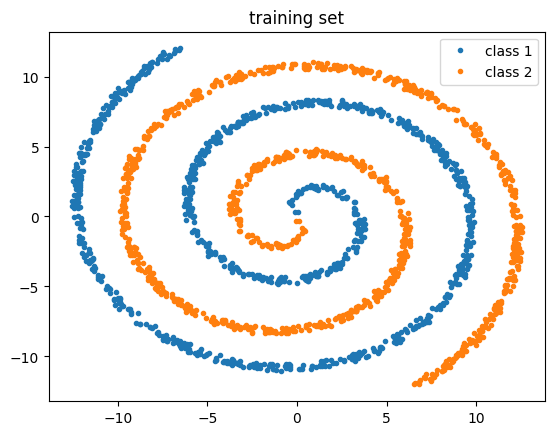

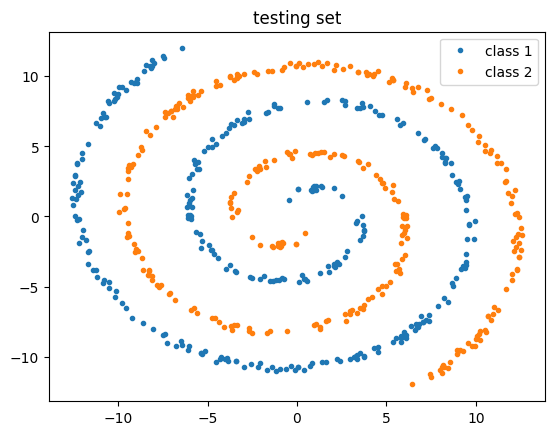

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import json

np.random.seed(42)
tf.random.set_seed(42)

# create dataset: two spirals
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    np.random.seed(0)
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y1 = twospirals(1000)
y = [0] * len(y1)
for i in range(len(y1)):
    if abs(y1[i] - 1) < abs(y1[i]):
        y[i] = 1
    else:
        y[i] = 0
y = np.array(y)
Xt, yt1 = twospirals(300)
yt = [0] * len(yt1)
for i in range(len(yt1)):
    if abs(yt1[i] - 1) < abs(yt1[i]):
        yt[i] = 1
    else:
        yt[i] = 0
yt = np.array(yt)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

plt.title('testing set')
plt.plot(Xt[yt==0,0], Xt[yt==0,1], '.', label='class 1')
plt.plot(Xt[yt==1,0], Xt[yt==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [2]:
def plot_decision_boundary(nn, X, y, resolution=0.1):
    """
    Plot the decision boundary for a neural network model.

    Args:
    nn: Trained neural network model (Keras model).
    X: Input data with exactly 2 features for visualization (shape: [n_samples, 2]).
    y: True labels corresponding to the input data (shape: [n_samples]).
    resolution: The resolution of the decision boundary grid.
    """
    assert X.shape[1] == 2, "X must have exactly 2 features for decision boundary visualization."

    # Define grid range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]  # Combine into (n_samples, 2)

    # Predict class probabilities or labels for the grid
    Z = nn.predict(grid)

    # Handle cases where the model outputs probabilities (softmax) or binary labels
    if Z.shape[1] > 1:  # For softmax outputs, take the class with the highest probability
        Z = np.argmax(Z, axis=1)
    else:  # For binary classification, threshold at 0.5
        Z = (Z > 0.5).astype(int)

    # Reshape predictions to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm, edgecolor="k")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

In [3]:
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)

## Neural Network

In [4]:
def standard_nn(input_shape=(2,), layer_sizes = [8], num_classes=2):
    """
    Creates a simple standard feedforward neural network.

    Args:
    input_shape: tuple, the shape of the input data (excluding batch size).
    layer_sizes: list of int, the number of neurons in each hidden layer.
    num_classes: int, the number of output classes.

    Returns:
    A Keras Model representing the neural network.
    """
    # Step 1: Setup Input Layer
    x_input = tf.keras.layers.Input(input_shape)

    # Step 2: Add Hidden Layers
    # Fully connected layer 1
    x = tf.keras.layers.Dense(layer_sizes[0], activation='relu')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)

    for layer_size in layer_sizes[1:]:
        x = tf.keras.layers.Dense(layer_size, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # Step 3: Output Layer
    # Use softmax activation for classification
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Step 4: Create Model
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="StandardNN")

    return model

### Some Examples

In [ ]:
model = standard_nn(input_shape=(2,), layer_sizes=[8] * 5, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 490 (1.91 KB)

 Trainable params: 410 (1.60 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9068 - loss: 0.2243
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.2533
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8968 - loss: 0.2636
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9161 - loss: 0.2290
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2345
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8917 - loss: 0.2626
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.1808
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9119 - loss: 0.2060
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9069 - loss: 0.2418
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9118 - loss: 0.2074
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.2383
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - lo

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


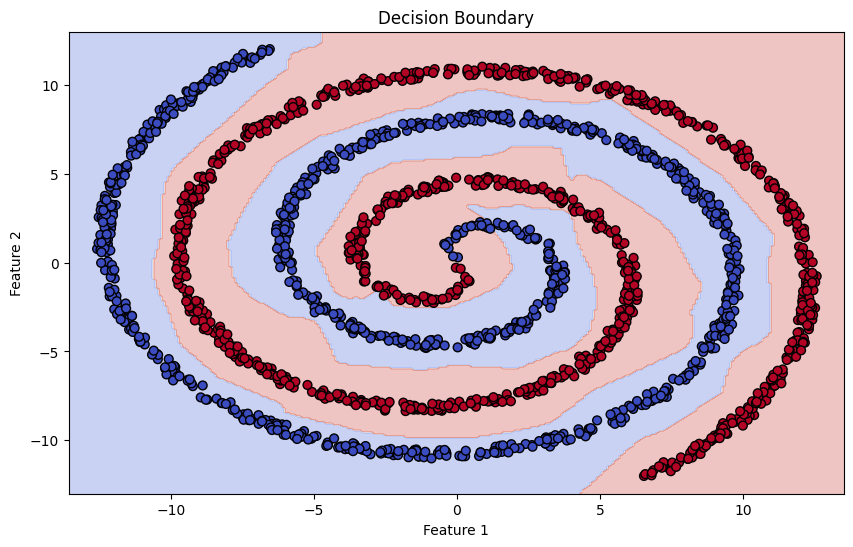

In [ ]:
plot_decision_boundary(model, X, y)

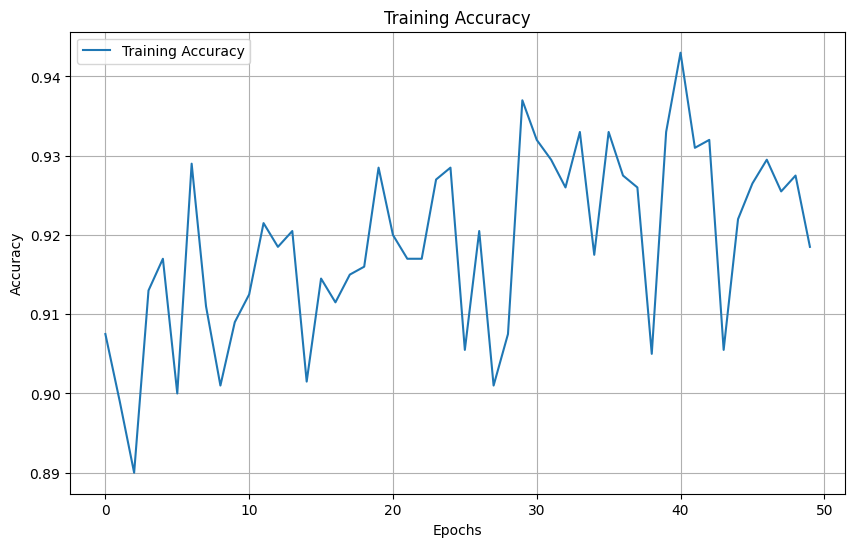

In [ ]:
plot_history(history.history['accuracy'])

In [ ]:
model = standard_nn(input_shape=(2,), layer_sizes=[8] * 40, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_104              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,130 (16.13 KB)

 Trainable params: 3,490 (13.63 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.4985 - loss: 0.9277
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5071 - loss: 0.7551
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4892 - loss: 0.7253
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4918 - loss: 0.7110
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4741 - loss: 0.7107
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5042 - loss: 0.7017
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5084 - loss: 0.7013
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4971 - loss: 0.7026
Epoch 9/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4833 - loss: 0.7028
Epoch 10/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5056 - loss: 0.6981
Epoch 11/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5139 - loss: 0.6949
Epoch 12/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/ste

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


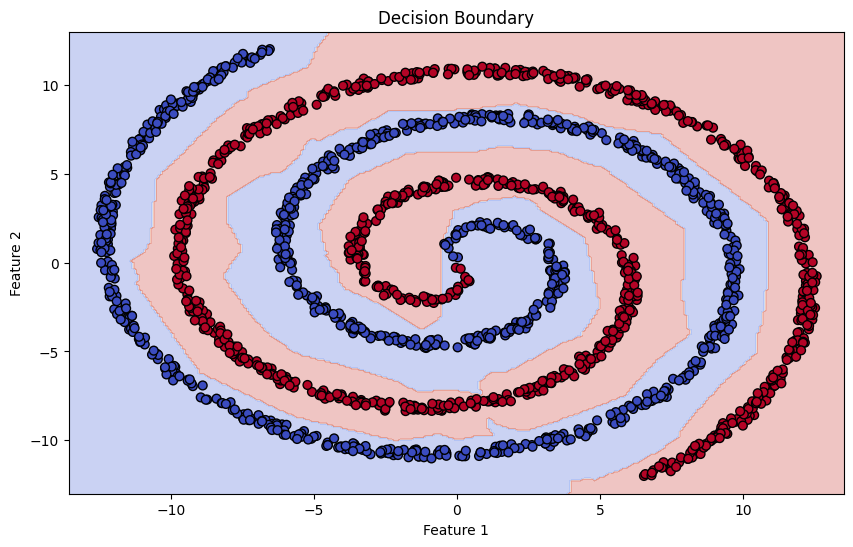

In [ ]:
plot_decision_boundary(model, X, y)

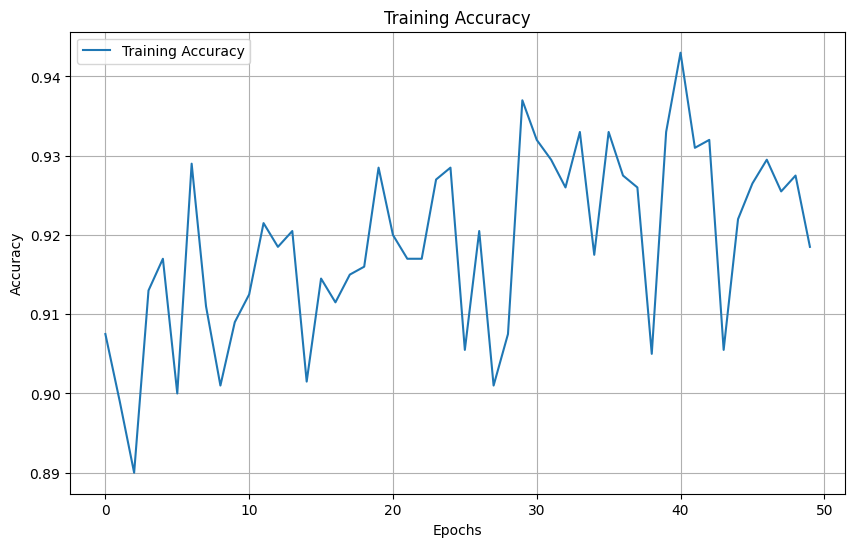

In [ ]:
plot_history(history.history['accuracy'])

## Residual Network

In [3]:
def residual_nn(input_shape=(2,), layer_sizes = [8], h=1, num_classes=2):
    """
    Creates a simple residual neural network.

    Args:
    input_shape: tuple, the shape of the input data (excluding batch size).
    layer_sizes: list of int, the number of neurons in each hidden layer.
    num_classes: int, the number of output classes.

    Returns:
    A Keras Model representing the residual neural network.
    """
    # Step 1: Setup Input Layer
    x_input = tf.keras.layers.Input(input_shape)

    # Step 2: Add Hidden Layers
    # Fully connected layer 1
    x = tf.keras.layers.Dense(layer_sizes[0], activation='relu')(x_input)

    for layer_size in layer_sizes[1:]:
        x_skip = x
        if h != 1:
          x_skip = tf.keras.layers.Lambda(lambda x:  h * x)(x_skip)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(layer_size, activation='relu')(x)
        x = tf.keras.layers.Add()([x, x_skip])

    # Step 3: Output Layer
    # Use softmax activation for classification
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Step 4: Create Model
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResidualNN")

    return model

### Some Examples

In [ ]:
model = residual_nn(input_shape=(2,), layer_sizes=[8] * 5, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 8)              │             24 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 8)              │             32 │ dense_55[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_56 (Dense)          │ (None, 8)              │             72 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 8)              │              0 │ dense_56[0][0],        │
│                           │                        │                │ dense_55[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 8)              │             32 │ add_5[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_57 (Dense)          │ (None, 8)              │             72 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 8)              │              0 │ dense_57[0][0],        │
│                           │                        │                │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 8)              │             32 │ add_6[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 8)              │             72 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 8)              │              0 │ dense_58[0][0],        │
│                           │                        │                │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 8)              │             32 │ add_7[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 8)              │             72 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 8)              │              0 │ dense_59[0][0],        │
│                           │                        │                │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 2)              │             18 │ add_8[0][0]            │
└──────────────────────

 Total params: 458 (1.79 KB)

 Trainable params: 394 (1.54 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5327 - loss: 1.8085
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5880 - loss: 0.8142
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5721 - loss: 0.7166
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5669 - loss: 0.6860
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5928 - loss: 0.6563
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5932 - loss: 0.6546
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5858 - loss: 0.6419
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6163 - loss: 0.6344
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6194 - loss: 0.6354
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6286 - loss: 0.6244
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6090 - loss: 0.6209
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6363 - lo

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


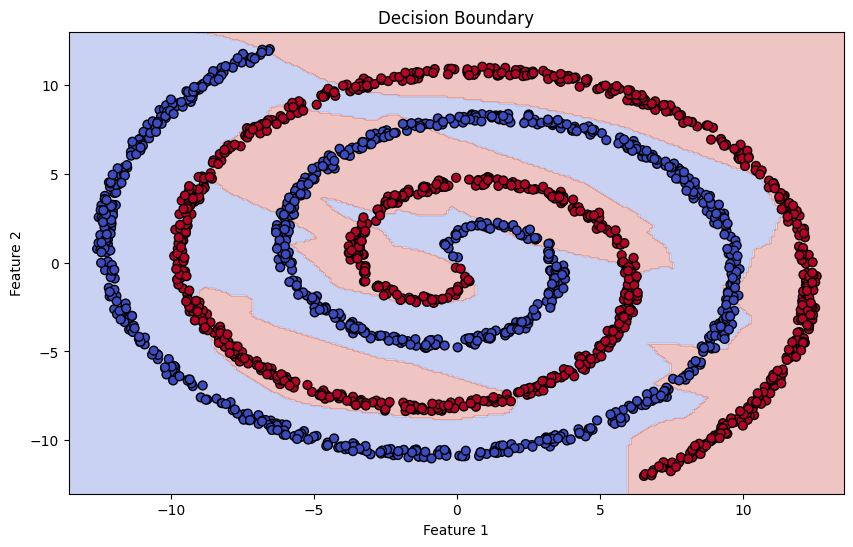

In [ ]:
plot_decision_boundary(model, X, y)

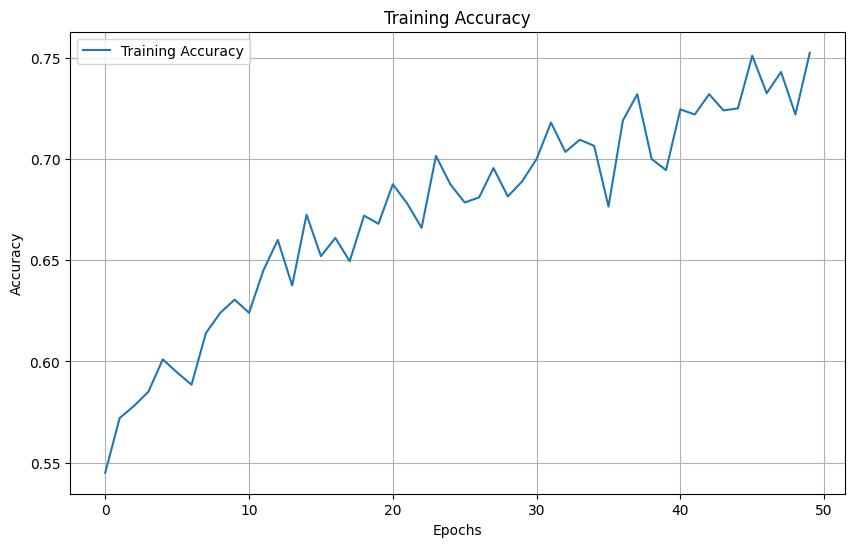

In [ ]:
plot_history(history.history['accuracy'])

## Runge-Kutta Networks

In [6]:
class RungeKuttaMethod:
    def __init__(self, A, b, c=None):
        if not (isinstance(A, np.ndarray) and isinstance(b, np.ndarray) and isinstance(c, np.ndarray)):
            raise TypeError("A, b, and c must all be numpy arrays.")

        # Check dimensions
        s = len(b)
        if A.shape != (s, s):
            raise ValueError(f"A must be a square matrix of shape ({s}, {s}).")
        if c is not None and c.shape != (s,):
            raise ValueError(f"c must be a vector of shape ({s},).")

        # Assign attributes
        self.A = A
        self.b = b
        self.c = c
        self.stages = s

    def classify(self):
        """Classify the Runge-Kutta method."""
        A = self.A
        s = A.shape[0]

        # Check for explicit (strictly upper triangular)
        if np.allclose(A, np.triu(A, k=1)):
            return "Explicit"

        # Check for implicit
        is_implicit = not np.allclose(A, np.triu(A, k=1))
        if is_implicit:
            # Check for DIRK (diagonally implicit)
            if np.allclose(A, np.tril(A)) and np.all(A.diagonal() != 0):
                if np.allclose(A.diagonal(), A[0, 0]):
                    return "SIRK"  # Diagonal elements are identical
                return "DIRK"  # Diagonal elements are not identical

            # General implicit
            return "Implicit"

        # Otherwise, no classification fits (should not occur)
        return "Unknown"

In [7]:
def runge_kutta_nn(rk, h=1, net_type="stage-wise", input_shape=(2,), layer_sizes = [8], num_classes=2):
    """
    Creates a simple residual neural network.

    Args:
    rk: runge-kutta method.
    h: scaling hyperparameter for skip connection.
    input_shape: tuple, the shape of the input data (excluding batch size).
    layer_sizes: list of int, the number of neurons in each hidden layer.
    num_classes: int, the number of output classes.

    Returns:
    A Keras Model representing the Runge-Kutta neural network.
    """
    # Step 1: Setup Input Layer
    x_input = tf.keras.layers.Input(input_shape)

    # Step 2: Add Hidden Layers
    x = tf.keras.layers.Dense(layer_sizes[0], activation='relu')(x_input)

    for layer_idx, layer_size in enumerate(layer_sizes[1:]):
        if not net_type == "stage-wise":
            dense_layer = tf.keras.layers.Dense(layer_size, activation='relu')
        xs = [0] * rk.stages
        F = [0] * rk.stages

        for stage_idx in range(rk.stages):
            xs[stage_idx] = x
            for j in range(stage_idx):
                x_temp = tf.keras.layers.Lambda(lambda x: h * rk.A[stage_idx][j] * x)(F[j])
                xs[stage_idx] = tf.keras.layers.Add()([xs[stage_idx], x_temp])

            if net_type == "stage-wise":
                F[stage_idx] = tf.keras.layers.Dense(layer_size, activation='relu')(xs[stage_idx])
            else:
                F[stage_idx] = dense_layer(xs[stage_idx])


        for stage_idx in range(rk.stages):
            x_temp = tf.keras.layers.Lambda(lambda x:  h * rk.b[stage_idx] * x)(F[stage_idx])
            x = tf.keras.layers.Add()([x, x_temp])

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)


    # Step 3: Output Layer
    # Use softmax activation for classification
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Step 4: Create Model
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="RungeKuttaNN")

    return model

In [8]:
# first order
explicit_euler = RungeKuttaMethod(np.array([[0]]), np.array([1]), np.array([0]))

# second order
A_heun = np.array([[0, 0],
                   [1, 0]])
b_heun = np.array([0.5, 0.5])
c_heun = np.array([0, 1])
heun = RungeKuttaMethod(A=A_heun, b=b_heun, c=c_heun)

# 4th order
A = np.array([[0, 0, 0, 0],
              [0.5, 0, 0, 0],
              [0, 0.5, 0, 0],
              [0, 0, 1, 0]])

b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1])
rk4 = RungeKuttaMethod(A=A, b=b, c=c)

# 8th order
A = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1/5, 0, 0, 0, 0, 0, 0, 0],
    [3/10, 3/10, 0, 0, 0, 0, 0, 0],
    [5/12, -5/12, 10/12, 0, 0, 0, 0, 0],
    [7/8, 0, -7/8, 8/8, 0, 0, 0, 0],
    [1/2, 0, 0, -1/2, 1/2, 0, 0, 0],
    [7/8, 0, 0, -7/8, 8/8, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1]
])
b = np.array([1/8, 3/8, 1/8, 3/8, 1/8, 7/8, 1/8, 1/8])
c = np.array([0, 1/5, 3/10, 5/12, 7/8, 1/2, 7/8, 1])
rk8 = RungeKuttaMethod(A=A, b=b, c=c)

# bad method: first order
stages = 4
A = np.zeros((stages, stages))
b = np.ones(stages) / stages
c = np.linspace(0, 1, stages)
rkbad = RungeKuttaMethod(A=A, b=b, c=c)

### Some Examples

In [ ]:
model = runge_kutta_nn(rk=explicit_euler, net_type="layer-wise", input_shape=(2,), layer_sizes=[8] * 5, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_118 (Dense)         │ (None, 8)              │             24 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_119 (Dense)         │ (None, 8)              │             72 │ dense_118[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_53 (Lambda)        │ (None, 8)              │              0 │ dense_119[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_72 (Add)              │ (None, 8)              │              0 │ dense_118[0][0],       │
│                           │                        │                │ lambda_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 8)              │              0 │ add_72[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_71    │ (None, 8)              │             32 │ activation_24[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_120 (Dense)         │ (None, 8)              │             72 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_54 (Lambda)        │ (None, 8)              │              0 │ dense_120[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_73 (Add)              │ (None, 8)              │              0 │ batch_normalization_7… │
│                           │                        │                │ lambda_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 8)              │              0 │ add_73[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 8)              │             32 │ activation_25[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_121 (Dense)         │ (None, 8)              │             72 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_55 (Lambda)        │ (None, 8)              │              0 │ dense_121[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_74 (Add)              │ (None, 8)              │              0 │ batch_normalization_7… │
│                           │                        │                │ lambda_55[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_26        

 Total params: 458 (1.79 KB)

 Trainable params: 394 (1.54 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4783 - loss: 0.9048
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5019 - loss: 0.6913
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5766 - loss: 0.6509
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6298 - loss: 0.6255
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6385 - loss: 0.6094
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6349 - loss: 0.6104
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6677 - loss: 0.5670
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - loss: 0.5543
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7090 - loss: 0.5294
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7153 - loss: 0.5059
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.4685
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7692 - lo

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


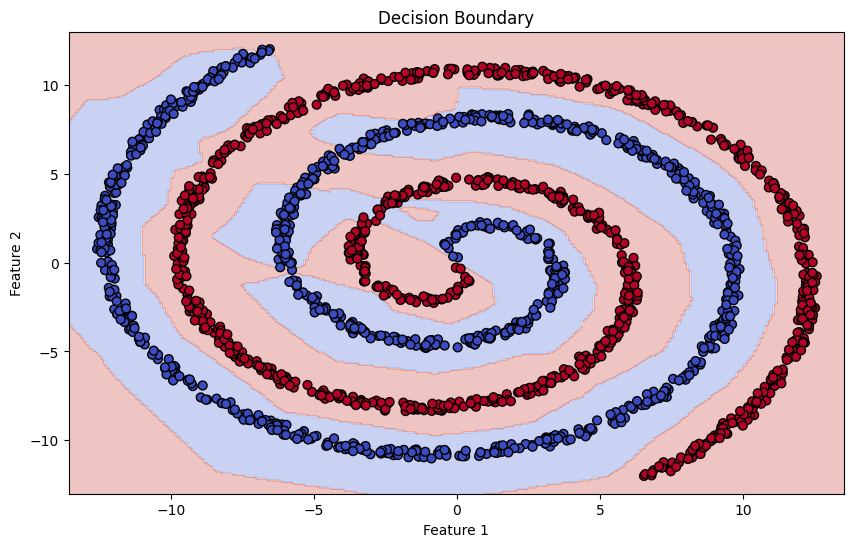

In [ ]:
plot_decision_boundary(model, X, y)

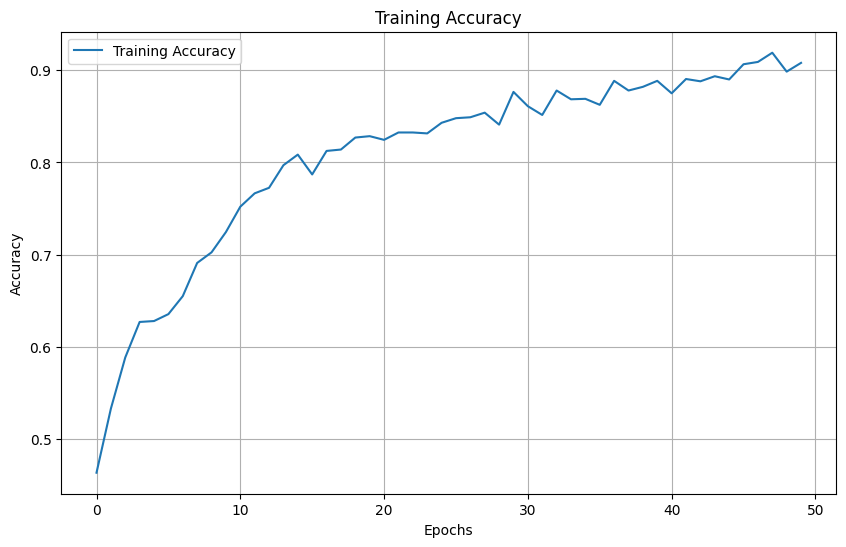

In [ ]:
plot_history(history.history['accuracy'])

In [ ]:
A = np.array([[0, 0, 0, 0],
              [0.5, 0, 0, 0],
              [0, 0.5, 0, 0],
              [0, 0, 1, 0]])

b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1])
rk4 = RungeKuttaMethod(A=A, b=b, c=c)
model = runge_kutta_nn(rk=rk4, net_type="layer-wise", input_shape=(2,), layer_sizes=[8] * 5, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_124 (Dense)         │ (None, 8)              │             24 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_125 (Dense)         │ (None, 8)              │             72 │ dense_124[0][0],       │
│                           │                        │                │ add_76[0][0],          │
│                           │                        │                │ add_78[0][0],          │
│                           │                        │                │ add_81[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_57 (Lambda)        │ (None, 8)              │              0 │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_76 (Add)              │ (None, 8)              │              0 │ dense_124[0][0],       │
│                           │                        │                │ lambda_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_58 (Lambda)        │ (None, 8)              │              0 │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_77 (Add)              │ (None, 8)              │              0 │ dense_124[0][0],       │
│                           │                        │                │ lambda_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_59 (Lambda)        │ (None, 8)              │              0 │ dense_125[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_78 (Add)              │ (None, 8)              │              0 │ add_77[0][0],          │
│                           │                        │                │ lambda_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_60 (Lambda)        │ (None, 8)              │              0 │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_79 (Add)              │ (None, 8)              │              0 │ dense_124[0][0],       │
│                           │                        │                │ lambda_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_61 (Lambda)        │ (None, 8)              │              0 │ dense_125[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_63 (Lambda)        │ (None, 8)              │              0 │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_80 (Add)              │ (None, 8)              │              0 │ add_79[0][0],          │
│                           │                        │                │ lambda_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_62 (Lambda)        │ (None, 8)              │              0 │ dense_125[2][0]        │
├──────────────────────

 Total params: 458 (1.79 KB)

 Trainable params: 394 (1.54 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5570 - loss: 0.7055
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5960 - loss: 0.6392
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6135 - loss: 0.6265
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6410 - loss: 0.5973
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6759 - loss: 0.5537
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7085 - loss: 0.5233
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6970 - loss: 0.5133
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7407 - loss: 0.4799
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.4588
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7367 - loss: 0.4510
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7776 - loss: 0.4100
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - lo

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


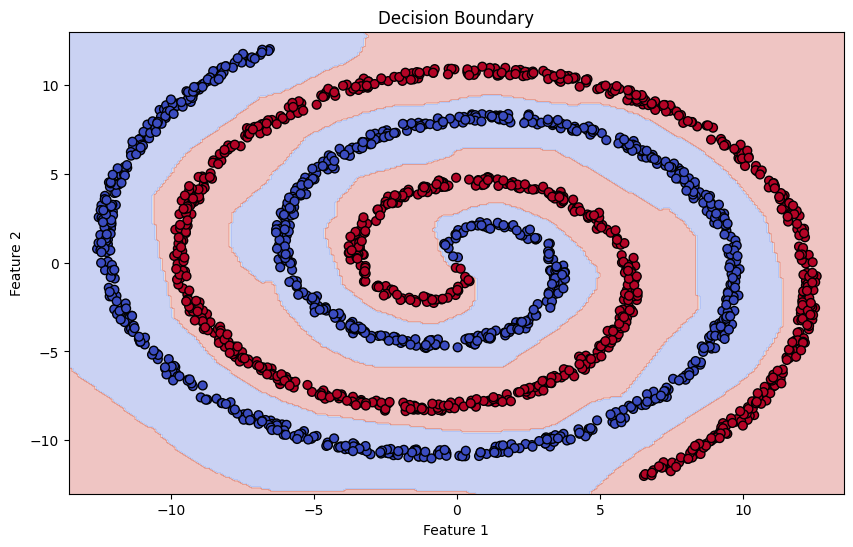

In [ ]:
plot_decision_boundary(model, X, y)

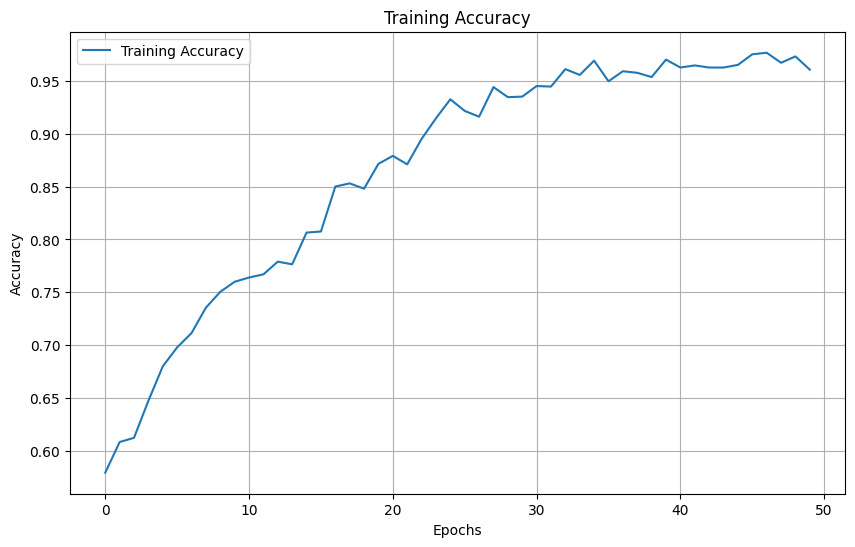

In [ ]:
plot_history(history.history['accuracy'])

In [ ]:
model = runge_kutta_nn(rk=rk4, net_type="layer-wise", input_shape=(2,), layer_sizes=[8] * 40, num_classes=2)
model.summary()

Model: "StandardNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_193 (Dense)         │ (None, 8)              │             24 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_194 (Dense)         │ (None, 8)              │             72 │ dense_193[0][0],       │
│                           │                        │                │ add_116[0][0],         │
│                           │                        │                │ add_118[0][0],         │
│                           │                        │                │ add_121[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_97 (Lambda)        │ (None, 8)              │              0 │ dense_194[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_116 (Add)             │ (None, 8)              │              0 │ dense_193[0][0],       │
│                           │                        │                │ lambda_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_98 (Lambda)        │ (None, 8)              │              0 │ dense_194[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_117 (Add)             │ (None, 8)              │              0 │ dense_193[0][0],       │
│                           │                        │                │ lambda_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_99 (Lambda)        │ (None, 8)              │              0 │ dense_194[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_118 (Add)             │ (None, 8)              │              0 │ add_117[0][0],         │
│                           │                        │                │ lambda_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_100 (Lambda)       │ (None, 8)              │              0 │ dense_194[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_119 (Add)             │ (None, 8)              │              0 │ dense_193[0][0],       │
│                           │                        │                │ lambda_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_101 (Lambda)       │ (None, 8)              │              0 │ dense_194[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_103 (Lambda)       │ (None, 8)              │              0 │ dense_194[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_120 (Add)             │ (None, 8)              │              0 │ add_119[0][0],         │
│                           │                        │                │ lambda_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_102 (Lambda)       │ (None, 8)              │              0 │ dense_194[2][0]        │
├──────────────────────

 Total params: 4,098 (16.01 KB)

 Trainable params: 3,474 (13.57 KB)

 Non-trainable params: 624 (2.44 KB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.5476 - loss: 0.6643
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5684 - loss: 0.6692
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5654 - loss: 0.6523
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5751 - loss: 0.6696
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5631 - loss: 0.6609
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5686 - loss: 0.6558
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5581 - loss: 0.6650
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5653 - loss: 0.6638
Epoch 9/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5689 - loss: 0.6560
Epoch 10/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5693 - loss: 0.6532
Epoch 11/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5656 - loss: 0.6612
Epoch 12/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/ste

2219/2219 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step


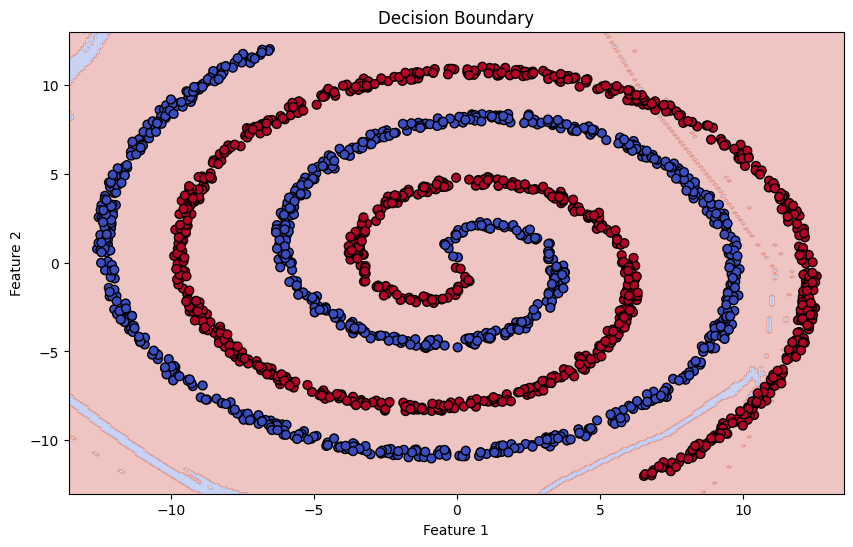

In [ ]:
plot_decision_boundary(model, X, y)

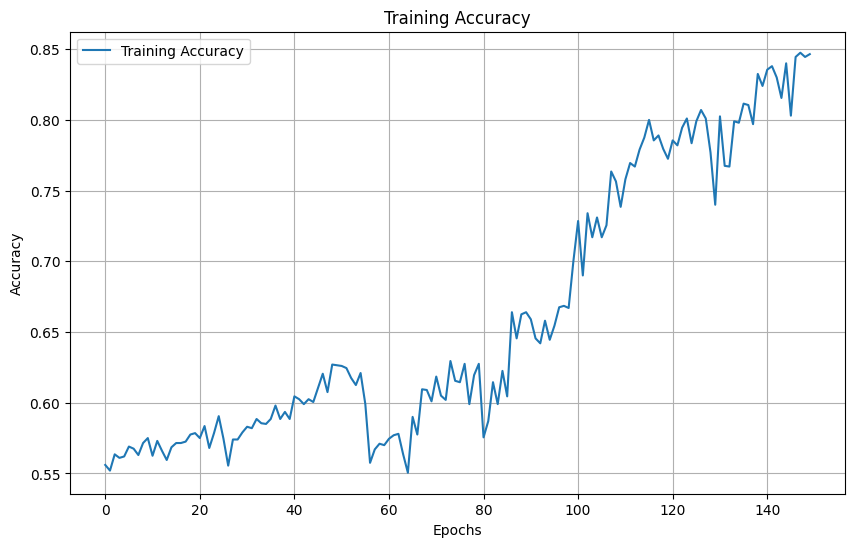

In [ ]:
plot_history(history.history['accuracy'])

## Experiment 1

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Define methods and names
methods = [explicit_euler, heun, rk4, rk8, rkbad]
method_names = ["Euler", "Heun", "RK4", "RK8", "RKBad"]
depths = range(50, 51, 5)

# Ensure the base directory exists for storing models
base_dir = "ml_paper/models"
os.makedirs(base_dir, exist_ok=True)

# Dictionaries to store runtime and history data
runtime_data = {
    'Depth': [],
    'Model': [],
    'Runtime': []
}

history_data = {
    'Depth': [],
    'Epoch': [],
    'Model': [],
    'Loss': [],
    'Accuracy': [],
    "Val_loss": [],
    "Val_accuracy": []
}

for depth in depths:
    print(f"Depth: {depth}")
    # Create directories for the different types of models
    method_dir = os.path.join(base_dir, "runge_kutta", f"depth_{depth}")
    os.makedirs(method_dir, exist_ok=True)
    standard_dir = os.path.join(base_dir, "standard", f"depth_{depth}")
    os.makedirs(standard_dir, exist_ok=True)
    residual_dir = os.path.join(base_dir, "residual", f"depth_{depth}")
    os.makedirs(residual_dir, exist_ok=True)

    # Runge-Kutta nets
    for method, method_name in zip(methods, method_names):
        print(f"Net: {method_name}")
        start_time = time.time()
        model = runge_kutta_nn(rk=method, net_type="layer-wise", input_shape=(2,), layer_sizes=[8] * depth, num_classes=2)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X, y, epochs=200, batch_size=32, validation_data=(Xt, yt), verbose=0)
        runtime = time.time() - start_time

        # Save the runtime to the dictionary
        runtime_data['Depth'].append(depth)
        runtime_data['Model'].append(method_name)
        runtime_data['Runtime'].append(runtime)

        # Save model
        # model.save(os.path.join(method_dir, f"{method_name}_depth_{depth}.keras"))

        # Collect loss and accuracy from history for each epoch
        for epoch in range(len(history.history['loss'])):
            history_data['Depth'].append(depth)
            history_data['Epoch'].append(epoch)
            history_data['Model'].append(method_name)
            history_data['Loss'].append(history.history['loss'][epoch])
            history_data["Accuracy"].append(history.history['accuracy'][epoch])
            history_data["Val_loss"].append(history.history['val_loss'][epoch])
            history_data["Val_accuracy"].append(history.history['val_accuracy'][epoch])

        # Clear the session and free up memory
        del model
        tf.keras.backend.clear_session()

    # Standard net
    print("Net: Standard")
    start_time = time.time()
    model = standard_nn(input_shape=(2,), layer_sizes=[8] * depth, num_classes=2)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X, y, epochs=200, batch_size=32, validation_data=(Xt, yt), verbose=0)
    runtime = time.time() - start_time

    runtime_data['Depth'].append(depth)
    runtime_data['Model'].append('Standard')
    runtime_data['Runtime'].append(runtime)
    # Save model
    # model.save(os.path.join(standard_dir, f"standard_depth_{depth}.keras"))

    # Collect loss and accuracy from history for each epoch
    for epoch in range(len(history.history['loss'])):
        history_data['Depth'].append(depth)
        history_data['Epoch'].append(epoch)
        history_data['Model'].append('Standard')
        history_data['Loss'].append(history.history['loss'][epoch])
        history_data['Accuracy'].append(history.history['accuracy'][epoch])
        history_data["Val_loss"].append(history.history['val_loss'][epoch])
        history_data["Val_accuracy"].append(history.history['val_accuracy'][epoch])

    # Clear the session and free up memory
    del model
    tf.keras.backend.clear_session()

    # Residual net
    print("Net: Residual")
    start_time = time.time()
    model = residual_nn(input_shape=(2,), layer_sizes=[8] * depth, num_classes=2)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X, y, epochs=200, batch_size=32, validation_data=(Xt, yt), verbose=0)
    runtime = time.time() - start_time

    runtime_data['Depth'].append(depth)
    runtime_data['Model'].append('Residual')
    runtime_data['Runtime'].append(runtime)

    # Save model
    # model.save(os.path.join(residual_dir, f"residual_depth_{depth}.keras"))

    # Collect loss and accuracy from history for each epoch
    for epoch in range(len(history.history['loss'])):
        history_data['Depth'].append(depth)
        history_data['Epoch'].append(epoch)
        history_data['Model'].append('Residual')
        history_data['Loss'].append(history.history['loss'][epoch])
        history_data['Accuracy'].append(history.history['accuracy'][epoch])
        history_data["Val_loss"].append(history.history['val_loss'][epoch])
        history_data["Val_accuracy"].append(history.history['val_accuracy'][epoch])

    # Clear the session and free up memory
    del model
    tf.keras.backend.clear_session()

    # Convert runtime data and history data to DataFrames
    runtime_df = pd.DataFrame(runtime_data)
    history_df = pd.DataFrame(history_data)

    # Write both DataFrames to Excel with separate sheets
    with pd.ExcelWriter(f'/content/drive/MyDrive/ml_paper/model_performance_{depth}.xlsx') as writer:
        runtime_df.to_excel(writer, sheet_name='Runtimes', index=False)
        history_df.to_excel(writer, sheet_name='History', index=False)
        runtime_data = {
            'Depth': [],
            'Model': [],
            'Runtime': []
        }

        history_data = {
            'Depth': [],
            'Epoch': [],
            'Model': [],
            'Loss': [],
            'Accuracy': [],
            "Val_loss": [],
            "Val_accuracy": []
        }

Depth: 50
Net: Euler
Net: Heun
Net: RK4
Net: RK8
Net: RKBad
Net: Standard
Net: Residual


The graphs are created with tableau based on the dataframes.

## Experiment 2

In [6]:
# Define methods and names
hs = [1, 1.5]
depth = 50

# Ensure the base directory exists for storing models
base_dir = "ml_paper/models"

# Dictionaries to store runtime and history data
runtime_data = {
    'Depth': [],
    'Model': [],
    'Runtime': []
}

history_data = {
    'Depth': [],
    'Epoch': [],
    'Model': [],
    'Loss': [],
    'Accuracy': [],
    "Val_loss": [],
    "Val_accuracy": []
}

for h in hs:
    print(f"h: {h}")

    # Residual net
    print("Net: Residual")
    start_time = time.time()
    model = residual_nn(input_shape=(2,), layer_sizes=[8] * depth, h=h, num_classes=2)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X, y, epochs=200, batch_size=32, validation_data=(Xt, yt), verbose=0)
    runtime = time.time() - start_time

    runtime_data['Depth'].append(depth)
    runtime_data['Model'].append('Residual')
    runtime_data['Runtime'].append(runtime)

    # Save model
    # model.save(os.path.join(residual_dir, f"residual_depth_{depth}.keras"))

    # Collect loss and accuracy from history for each epoch
    for epoch in range(len(history.history['loss'])):
        history_data['Depth'].append(depth)
        history_data['Epoch'].append(epoch)
        history_data['Model'].append('Residual')
        history_data['Loss'].append(history.history['loss'][epoch])
        history_data['Accuracy'].append(history.history['accuracy'][epoch])
        history_data["Val_loss"].append(history.history['val_loss'][epoch])
        history_data["Val_accuracy"].append(history.history['val_accuracy'][epoch])

    # Clear the session and free up memory
    del model
    tf.keras.backend.clear_session()

    # Convert runtime data and history data to DataFrames
    runtime_df = pd.DataFrame(runtime_data)
    history_df = pd.DataFrame(history_data)

    # Write both DataFrames to Excel with separate sheets
    with pd.ExcelWriter(f'/content/drive/MyDrive/ml_paper/residual_performance_{h}.xlsx') as writer:
        runtime_df.to_excel(writer, sheet_name='Runtimes', index=False)
        history_df.to_excel(writer, sheet_name='History', index=False)
        runtime_data = {
            'Depth': [],
            'Model': [],
            'Runtime': []
        }

        history_data = {
            'Depth': [],
            'Epoch': [],
            'Model': [],
            'Loss': [],
            'Accuracy': [],
            "Val_loss": [],
            "Val_accuracy": []
        }

h: 1
Net: Residual
h: 1.5
Net: Residual
